In [1]:
import yfinance as yf
import pandas as pd
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

def fetch_data(ticker, start_date='2020-01-01', end_date='2024-01-01'):
    return yf.download(ticker, start=start_date, end=end_date)

def ewmac(price, vol, Lfast, Lslow):
    fast_ewma = price.ewm(span=Lfast, min_periods=1).mean()
    slow_ewma = price.ewm(span=Lslow, min_periods=1).mean()
    raw_ewmac = fast_ewma - slow_ewma
    return raw_ewmac / vol.ffill()

def calculate_ewmac_signals(data, parameters):
    composite_signal = pd.Series(0, index=data.index)
    for filter_speed in parameters:
        Lfast = filter_speed
        Lslow = 4 * filter_speed
        signal_name = f'EWMAC_{filter_speed}'
        data[signal_name] = scale_cap_forecast(ewmac(data['Close'], data['Volatility'], Lfast, Lslow))
        composite_signal += data[signal_name]
    data['Composite_Signal'] = composite_signal / len(parameters) 
    return data

def scale_cap_forecast(signals, cap=20):
    signals = signals * 10 / signals.abs().mean()
    return signals.clip(-cap, cap)

def calculate_pnl(trades, data, initial_capital, transaction_cost=0.001):
    trades['Position Change'] = trades['Position'].diff().fillna(0)
    trades['Position Cost'] = 0.0
    trades['Realized PnL'] = 0.0
    trades['Unrealized PnL'] = 0.0
    trades['Total PnL'] = 0.0
    trades['Account Size'] = initial_capital

    for i in range(1, len(trades)):
        position_change = trades['Position Change'].iloc[i]
        execution_price = data['Close'].iloc[i]
        previous_position = trades['Position'].iloc[i-1]
        position_cost = trades['Position Cost'].iloc[i-1]

        realized_pnl = 0.0

        if previous_position != 0:
            avg_position_price = position_cost / abs(previous_position)
        else:
            avg_position_price = 0

        if np.sign(position_change) == np.sign(previous_position):
            trades.loc[trades.index[i], 'Position Cost'] = position_cost + (position_change * execution_price)
        else:
            if abs(position_change) > abs(previous_position):
                realized_pnl = (execution_price - avg_position_price) * previous_position + (position_change + previous_position) * execution_price
                trades.loc[trades.index[i], 'Position Cost'] = (position_change + previous_position) * execution_price
            else:
                realized_pnl = (execution_price - avg_position_price) * position_change
                trades.loc[trades.index[i], 'Position Cost'] = position_cost + (position_change * execution_price)

            realized_pnl -= transaction_cost * abs(position_change) * execution_price
            trades.loc[trades.index[i], 'Realized PnL'] = realized_pnl

        trades.loc[trades.index[i], 'Account Size'] -= transaction_cost * abs(position_change) * execution_price

        if trades['Position'].iloc[i] != 0:
            trades.loc[trades.index[i], 'Unrealized PnL'] = trades['Position'].iloc[i] * (execution_price - avg_position_price)
        else:
            trades.loc[trades.index[i], 'Unrealized PnL'] = 0

        trades.loc[trades.index[i], 'Total PnL'] = trades['Realized PnL'].cumsum().iloc[i] + trades['Unrealized PnL'].iloc[i]
        trades.loc[trades.index[i], 'Account Size'] += trades['Unrealized PnL'].iloc[i]

    return trades

def adjust_trade_buffer(data, max_loss_sharpe, window=30):
    rolling_mean = data['Log_Returns'].rolling(window=window).mean()
    rolling_std = data['Log_Returns'].rolling(window=window).std()
    rolling_sharpe = rolling_mean / rolling_std
    trade_buffer = (rolling_sharpe.abs() / max_loss_sharpe).clip(lower=1)
    return trade_buffer

def calculate_backtest_metrics(trades, capital, strat):
    daily_pnl = trades['Total PnL'].diff().fillna(0)  # Calculate daily PnL
    cumulative_pnl = trades['Total PnL']
    daily_mean_return = daily_pnl.mean()
    daily_std_dev = daily_pnl.std()
    annualized_return = (daily_mean_return * 252) / capital
    annualized_std_dev = (daily_std_dev * np.sqrt(252)) / capital
    sharpe_ratio = annualized_return / annualized_std_dev 
    annualized_return_pct = annualized_return * 100
    drawdowns = cumulative_pnl - cumulative_pnl.cummax()
    max_drawdown = drawdowns.min()
    avg_drawdown = drawdowns.mean()
    avg_position = trades['Position'].abs().mean()
    total_turnover = trades['Position'].diff().abs().sum()
    annual_turnover = (total_turnover / avg_position / len(trades)) * 252
    skew = daily_pnl.skew()
    lower_tail = daily_pnl.quantile(0.05)
    upper_tail = daily_pnl.quantile(0.95)
    alpha = (cumulative_pnl.iloc[-1] / cumulative_pnl.std()) * np.sqrt(252)
    
    metrics = pd.DataFrame({
        "Initial Capital": capital,
        "Mean Annualised Return  %": annualized_return_pct,
        "Max Drawdown %": (max_drawdown / capital) * 100,
        "Avg Drawdown %": (avg_drawdown / capital) * 100,
        "Annual Standard Deviation %": annualized_std_dev * 100,
        "Sharpe Ratio": sharpe_ratio,
        "Annual Turnover": annual_turnover,
        "Skew": skew,
        "Lower Tail (5th percentile)": lower_tail,
        "Upper Tail (95th percentile)": upper_tail,
        "Cumulative PnL": cumulative_pnl.iloc[-1]
    }, index=[strat]).T
    
    return metrics

def calculate_position_size(capped_signals, risk_target, volatility, price, capital, instrument_weights, fx_rate, idm):
    multiplier = 1000
    weighted_signals = capped_signals.mul(instrument_weights, axis=1)
    average_signal = weighted_signals.sum(axis=1)
    position = round(average_signal * capital * idm * risk_target / (10 * multiplier * price * fx_rate * volatility), 0)
    return position

def plot_combined(trades, price, pnl, composite_signal):
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
                        row_heights=[1,1,1,1], vertical_spacing=0.05)

    fig.add_trace(go.Scatter(x=price.index, y=price, mode='lines', name='Price', line=dict(color='blue')), row=1, col=1)
    
    fig.add_trace(go.Scatter(x=pnl.index, y=pnl, mode='lines', name='PNL', line=dict(color='green')), row=2, col=1)
    
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'], mode='lines', name='Position Size', line=dict(color='red')), row=3, col=1)
    
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'] * (trades['Position'] > 0), mode='lines', fill='tozeroy', name='Long Position', fillcolor='rgba(0,255,0,0.3)', line=dict(width=0), hoverinfo='skip'), row=3, col=1)
    fig.add_trace(go.Scatter(x=trades.index, y=trades['Position'] * (trades['Position'] < 0), mode='lines', fill='tozeroy', name='Short Position', fillcolor='rgba(255,0,0,0.3)', line=dict(width=0), hoverinfo='skip'), row=3, col=1)
    
    for i in range(1, len(trades)):
        if trades['Position'].iloc[i] != 0 and trades['Position'].iloc[i - 1] == 0:
            fig.add_shape(type="line", xref="x", yref="paper", x0=trades.index[i], x1=trades.index[i], y0=0, y1=1, line=dict(color="green" if trades['Position'].iloc[i] > 0 else "red", width=1), opacity=0.1)

    fig.add_trace(go.Scatter(x=composite_signal.index, y=composite_signal, mode='lines', name='Composite Signal', line=dict(color='purple')), row=4, col=1)

    fig.update_layout(title='Combined Position Size, Underlying Price, PNL, and Composite Signal with Direction Change Indicators', xaxis_title='Date')

    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="PNL", row=2, col=1)
    fig.update_yaxes(title_text="Position Size", row=3, col=1)
    fig.update_yaxes(title_text="Composite Signal", row=4, col=1)
    
    fig.show()

def backtest(ticker='BZ=F', start_date='2020-01-01', end_date='2024-06-14', parameters=[4, 8, 16, 32, 64],
             risk_target=0.10, initial_capital=100000, plot=True, transaction_cost=0.01, max_loss_sharpe=0.05):
    strat = "EWMAC_" + '_'.join([str(i) for i in parameters])
    instrument_weights = 1
    fx_rate = 1.0
    idm = 1
    data = fetch_data(ticker, start_date, end_date)
    data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    data['Volatility'] = data['Log_Returns'].ewm(span=30, min_periods=0).std()
    data = calculate_ewmac_signals(data, parameters)
    signal_cols = [i for i in data.columns if "EWM" in i]
    data["Ideal Position Size"] = calculate_position_size(data[signal_cols], risk_target, data['Volatility'], data['Close'], initial_capital, instrument_weights, fx_rate, idm)
    data['Trade Buffer'] = adjust_trade_buffer(data, max_loss_sharpe)
    data['Position Size'] = data['Ideal Position Size'].where(
        (data['Ideal Position Size'] - data['Ideal Position Size'].shift(1)).abs() > data['Trade Buffer'],
        other=np.nan
    ).ffill().fillna(0)
    trades = pd.DataFrame(index=data.index)
    trades['Position'] = data["Position Size"]
    trades = calculate_pnl(trades, data, initial_capital, transaction_cost)
    backtest_metrics = calculate_backtest_metrics(trades, initial_capital, strat)
    pd.options.display.float_format = '{:.2f}'.format
    print(backtest_metrics.round(2))
    if plot:
        plot_combined(trades, data['Close'], trades['Total PnL'], data['Composite_Signal'])
    return trades, data

# Running the backtest
trades, data = backtest()


[*********************100%***********************]  1 of 1 completed
                              EWMAC_4_8_16_32_64
Initial Capital                        100000.00
Mean Annualised Return  %                  12.05
Max Drawdown %                            -22.34
Avg Drawdown %                             -7.82
Annual Standard Deviation %                12.97
Sharpe Ratio                                0.93
Annual Turnover                            22.97
Skew                                        1.59
Lower Tail (5th percentile)              -754.41
Upper Tail (95th percentile)             1170.85
Cumulative PnL                          53463.52


In [2]:
trades

,Position,Position Change,Position Cost,Realized PnL,Unrealized PnL,Total PnL,Account Size
Date,,,,,,,
2020-01-02,0.00,0.00,0.00,0.00,0.00,0.00,100000.00
2020-01-03,0.00,0.00,0.00,0.00,0.00,0.00,100000.00
2020-01-06,0.00,0.00,0.00,0.00,0.00,0.00,100000.00
2020-01-07,0.00,0.00,0.00,0.00,0.00,0.00,100000.00
2020-01-08,0.00,0.00,0.00,0.00,0.00,0.00,100000.00
...,...,...,...,...,...,...,...
2024-06-07,-34.00,0.00,-2704.38,0.00,-5411.46,46129.65,94588.54
2024-06-10,-23.00,11.00,-1806.45,1763.90,-3706.92,49598.08,96284.10
2024-06-11,-19.00,4.00,-1478.77,638.57,-3048.76,50894.81,96947.96


In [5]:
data

,Open,High,Low,Close,Adj Close,Volume,Log_Returns,Volatility,EWMAC_4,EWMAC_8,EWMAC_16,EWMAC_32,EWMAC_64,Composite_Signal,Ideal Position Size,Trade Buffer,Position Size
Date,,,,,,,,,,,,,,,,,
2020-01-02,66.47,66.57,65.73,66.25,66.25,25810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2020-01-03,66.29,69.48,66.22,68.60,68.60,78848,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2020-01-06,69.07,70.72,68.19,68.91,68.91,51933,0.00,0.02,1.78,0.67,0.24,0.09,0.04,0.56,2.00,NaN,0.00
2020-01-07,68.58,68.74,67.65,68.27,68.27,41178,-0.01,0.02,1.14,0.51,0.20,0.08,0.03,0.39,1.00,NaN,0.00
2020-01-08,68.47,71.99,64.94,65.44,65.44,85232,-0.04,0.03,-1.48,-0.38,-0.11,-0.03,-0.01,-0.40,-1.00,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-07,80.02,80.38,79.33,79.62,79.62,26371,-0.00,0.02,-13.80,-15.36,-10.32,-2.99,-0.45,-8.58,-35.00,4.82,-34.00
2024-06-10,79.41,82.16,79.35,81.63,81.63,36413,0.02,0.02,-6.68,-12.14,-9.24,-2.90,-0.52,-6.30,-23.00,3.79,-23.00
2024-06-11,81.97,82.36,81.20,81.92,81.92,35178,0.00,0.02,-2.47,-10.35,-8.98,-3.04,-0.62,-5.09,-19.00,3.14,-19.00


                               Value
Mean Daily PnL                 47.82
Std Dev Daily PnL             817.14
Median Daily PnL                0.00
Min Daily PnL              -12705.63
Max Daily PnL               13434.81
Mean Annualized Return (%)     12.05
Annualized Std Dev (%)         12.97
Skewness                        1.59
Kurtosis                      121.84
Quintile 20%                  -57.55
Quintile 40%                   -2.34
Quintile 60%                    7.51
Quintile 80%                   60.30
VaR 95%                      -754.41
CVaR 95%                    -1356.91


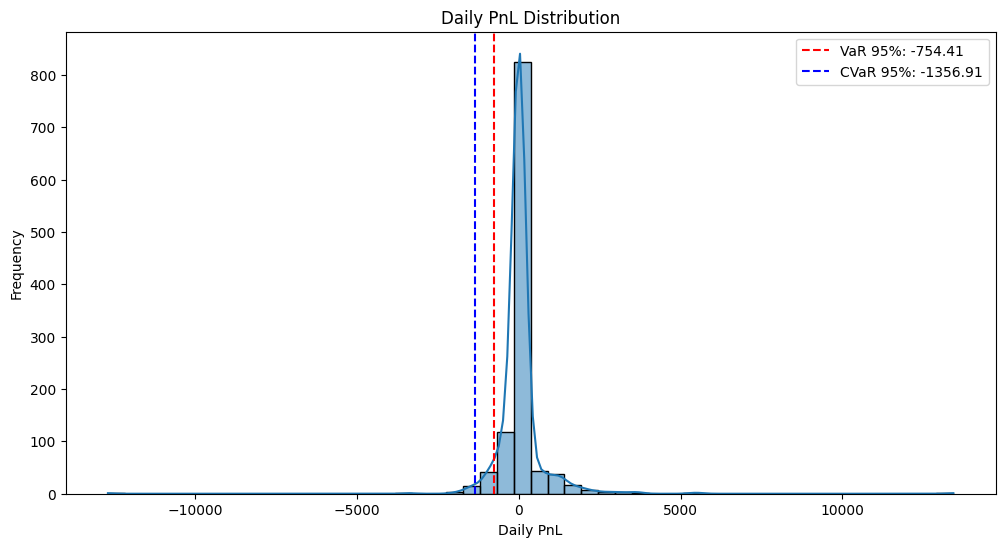

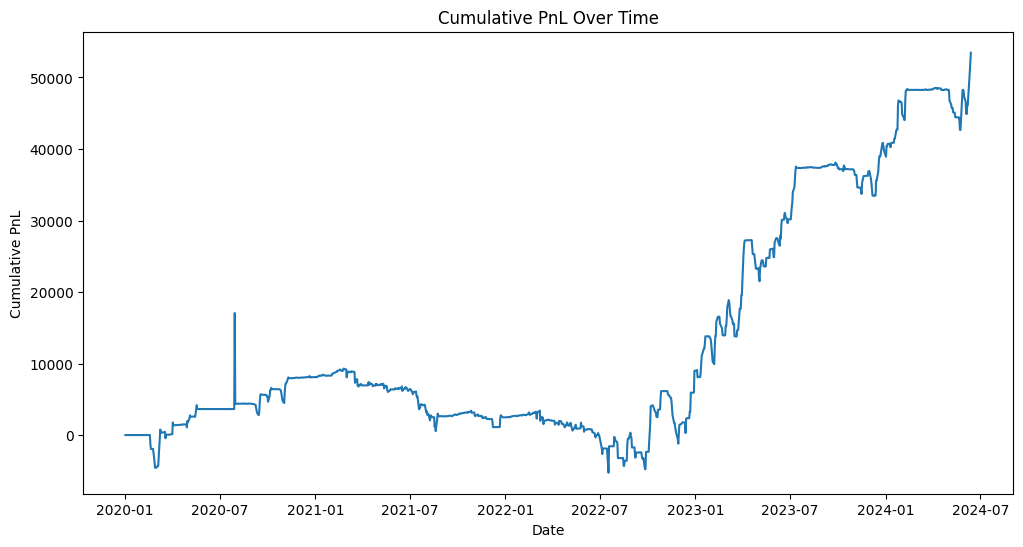

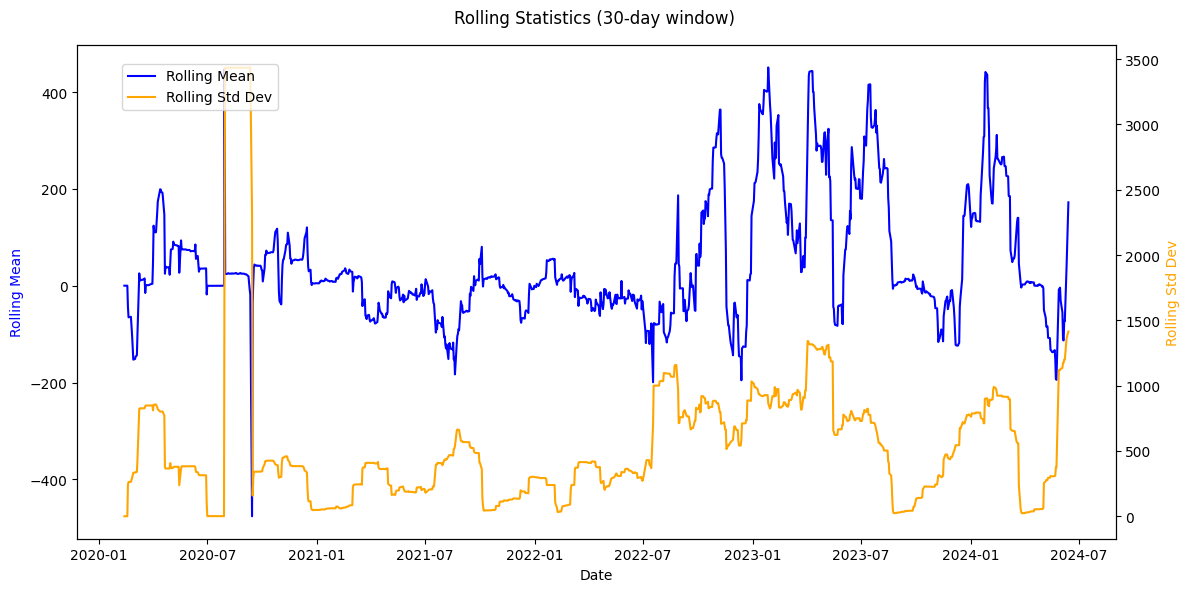

In [4]:
def analyze_performance(data, trades):
    daily_pnl = trades['Total PnL'].diff().fillna(0)
    cumulative_pnl = trades['Total PnL']
    initial_capital = trades['Account Size'].iloc[0]

    # Calculate basic statistics
    pnl_stats = {
        'Mean Daily PnL': daily_pnl.mean(),
        'Std Dev Daily PnL': daily_pnl.std(),
        'Median Daily PnL': daily_pnl.median(),
        'Min Daily PnL': daily_pnl.min(),
        'Max Daily PnL': daily_pnl.max(),
        'Mean Annualized Return (%)': (daily_pnl.mean() * 252) * 100 / initial_capital,
        'Annualized Std Dev (%)': (daily_pnl.std() * np.sqrt(252)) * 100 / initial_capital,
        'Skewness': daily_pnl.skew(),
        'Kurtosis': daily_pnl.kurtosis()
    }

    # Calculate quintiles
    pnl_quintiles = daily_pnl.quantile([0.2, 0.4, 0.6, 0.8]).to_dict()
    pnl_stats.update({f'Quintile {int(q*100)}%': v for q, v in pnl_quintiles.items()})

    # Calculate Value at Risk (VaR) and Conditional Value at Risk (CVaR)
    var_95 = np.percentile(daily_pnl, 5)
    cvar_95 = daily_pnl[daily_pnl <= var_95].mean()
    pnl_stats['VaR 95%'] = var_95
    pnl_stats['CVaR 95%'] = cvar_95

    # Calculate rolling statistics
    rolling_window = 30
    rolling_mean = daily_pnl.rolling(window=rolling_window).mean()
    rolling_std = daily_pnl.rolling(window=rolling_window).std()

    # Print basic statistics
    pnl_stats_df = pd.DataFrame.from_dict(pnl_stats, orient='index', columns=['Value'])
    print(pnl_stats_df)

    # Plot PnL distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(daily_pnl, bins=50, kde=True)
    plt.title('Daily PnL Distribution')
    plt.xlabel('Daily PnL')
    plt.ylabel('Frequency')
    plt.axvline(x=var_95, color='r', linestyle='--', label=f'VaR 95%: {var_95:.2f}')
    plt.axvline(x=cvar_95, color='b', linestyle='--', label=f'CVaR 95%: {cvar_95:.2f}')
    plt.legend()
    plt.show()

    # Plot cumulative PnL
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_pnl)
    plt.title('Cumulative PnL Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.show()

    # Plot rolling statistics
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(rolling_mean, color='blue', label='Rolling Mean')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Rolling Mean', color='blue')

    ax2 = ax1.twinx()
    ax2.plot(rolling_std, color='orange', label='Rolling Std Dev')
    ax2.set_ylabel('Rolling Std Dev', color='orange')

    fig.suptitle('Rolling Statistics (30-day window)')
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()
    
    return pnl_stats_df

performance_stats = analyze_performance(data, trades)